<a href="https://colab.research.google.com/github/piyalibanerjee/cs6440/blob/main/pbanerjee32MP2Ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NCHS Data Import

In [10]:
# LIBRARY IMPORT
import math
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from google.colab import files
uploaded = files.upload()
#Import data from the "Raw Data (Do not touch)" sheet in my excel deliverable (mini project 2.xlsx)

FILE_NAME = "mini project 2.xlsx" #NAME OF MY EXCEL DELIVERABLE
raw_data = pd.read_excel(io.BytesIO(uploaded[FILE_NAME]), sheet_name="Raw Data (Do not touch)", usecols=[1,2,3,4,5], header=1)

Saving mini project 2.xlsx to mini project 2 (4).xlsx


Data Cleansing

In [11]:
#Add new 'Demographic' column with the title of each mini-table that contains the demographic description for each row of data.
#When I imported from PDF to excel in the raw data excel sheet, there was a single row per title, placed in the first cell of the row.
#Titles were therefore in the first column ("RANK") of the raw data dataframe. In the title rows, the rest of the cells in the row were N/A. 
#I used this to identify the title rows and copy over the titles for the "Demographic" column.
raw_data['Demographic'] = raw_data.apply(lambda row: row["RANK"] if pd.isnull(row["Rate"]) else None, axis=1)

#Set-up for loop: assign first cell of new Demographic column the first title of the first mini-table to make loop easier to construct
raw_data['Demographic'][0] = "All races, both sexes, all ages"
num_rows = raw_data.shape[0]

#Loop through rows, assigning appropriate title with demographic description to each cell in the new Demographic column
for i in range(1, num_rows):
    if raw_data["Demographic"][i-1]!= None and not(pd.isnull(raw_data["Rate"][i])):
        raw_data["Demographic"][i] = raw_data["Demographic"][i-1];
#Display raw data dataframe with new Demographic column:
raw_data.head(20)

,RANK,Cause of Death,Number,Percent of Total Deaths,Rate,Demographic
0,...,All causes,2596993,100,821.5,"All races, both sexes, all ages"
1,1,"Diseases of heart (I00-I09,I11,I13,I20-I51)",611105,23.5,193.3,"All races, both sexes, all ages"
2,2,Malignant neoplasms (C00-C97),584881,22.5,185,"All races, both sexes, all ages"
3,3,Chronic lower respiratory diseases (J40-J47),149205,5.7,47.2,"All races, both sexes, all ages"
4,4,"Accidents (unintentional injuries) (V01-X59,Y8...",130557,5,41.3,"All races, both sexes, all ages"
5,5,Cerebrovascular diseases (I60-I69),128978,5,40.8,"All races, both sexes, all ages"
6,6,Alzheimer's disease (G30),84767,3.3,26.8,"All races, both sexes, all ages"
7,7,Diabetes mellitus (E10-E14),75578,2.9,23.9,"All races, both sexes, all ages"
8,8,Influenza and pneumonia (J09-J18),56979,2.2,18,"All races, both sexes, all ages"
9,9,"Nephritis, nephrotic syndrome and nephrosis (N...",47112,1.8,14.9,"All races, both sexes, all ages"


In [12]:
#The goal here is to create one large table with all the data. Remove unnecessary rows.

#Remove demographic info title rows since we now already have the demographic info in the new "Demographic" column
#create new cleaned_raw_data dataframe from the original raw_data dataframe by filtering out the title rows that have N/A values for all but the first column.
cleaned_raw_data = raw_data[pd.notnull(raw_data["Cause of Death"])].reset_index(drop=True)

#Since column headers have already been set, I can delete the extra rows with copies of the column header names
#Identify row as a copy of the column headers by filtering out rows that have one of the column headers in it (I used "Cause of Death").
cleaned_raw_data = cleaned_raw_data[cleaned_raw_data["Cause of Death"]!="Cause of Death"].reset_index(drop=True)

#The demographic title includes race, sex, and age segment -- it would be easier to analyze the data by these categories if they were split to their own columns
#Split strings in "Demographic" column by ", " delimiter and assign split strings into new "Race Segment", "Sex Segment", and "Age Segment" columns
demo_segments = cleaned_raw_data["Demographic"].str.split(", ", expand = True)
cleaned_raw_data["Race Segment"], cleaned_raw_data["Sex Segment"], cleaned_raw_data["Age Segment"] = demo_segments[0], demo_segments[1], demo_segments[2]
#We no longer need the "Demographic" column since that info is in the 3 new columns for each category
cleaned_raw_data.drop(columns =["Demographic"], inplace = True)
cleaned_raw_data.reset_index(drop=True)

#Display cleaned_raw_data with new demographic category columns
cleaned_raw_data.head(20)

,RANK,Cause of Death,Number,Percent of Total Deaths,Rate,Race Segment,Sex Segment,Age Segment
0,...,All causes,2596993,100,821.5,All races,both sexes,all ages
1,1,"Diseases of heart (I00-I09,I11,I13,I20-I51)",611105,23.5,193.3,All races,both sexes,all ages
2,2,Malignant neoplasms (C00-C97),584881,22.5,185,All races,both sexes,all ages
3,3,Chronic lower respiratory diseases (J40-J47),149205,5.7,47.2,All races,both sexes,all ages
4,4,"Accidents (unintentional injuries) (V01-X59,Y8...",130557,5,41.3,All races,both sexes,all ages
5,5,Cerebrovascular diseases (I60-I69),128978,5,40.8,All races,both sexes,all ages
6,6,Alzheimer's disease (G30),84767,3.3,26.8,All races,both sexes,all ages
7,7,Diabetes mellitus (E10-E14),75578,2.9,23.9,All races,both sexes,all ages
8,8,Influenza and pneumonia (J09-J18),56979,2.2,18,All races,both sexes,all ages
9,9,"Nephritis, nephrotic syndrome and nephrosis (N...",47112,1.8,14.9,All races,both sexes,all ages


In [13]:
#The "Rate" column included some data set to be '*'. I observed tha this was for rates that were less than 0.1. To clean up the data, I set these to be 0 rather than '*'
#to make analysis easier. I then dropped the original rate column to clean up the table.
cleaned_raw_data["Rate Modified"] = cleaned_raw_data.apply(lambda row: float(row["Rate"]) if row["Rate"]!="*" else 0, axis=1)
cleaned_raw_data.drop(columns =["Rate"], inplace = True)
cleaned_raw_data.reset_index(drop=True)

#Convert columns to be numeric rather than strings for easy calculations in the analysis section.
cleaned_raw_data["Number"] = pd.to_numeric(cleaned_raw_data["Number"])
cleaned_raw_data["Percent of Total Deaths"] = pd.to_numeric(cleaned_raw_data["Percent of Total Deaths"])
cleaned_raw_data.dtypes

RANK                        object
Cause of Death              object
Number                       int64
Percent of Total Deaths    float64
Race Segment                object
Sex Segment                 object
Age Segment                 object
Rate Modified              float64
dtype: object

In [14]:
#Map each "Age Segment" to a numeric "Age Segment Category" to make age analysis easier. It's easier to compare numbers than to compare strings, and the alphabetic order
#of the original "Age Segment" category wasn't the same as the order of increasing age category. 
age_segments = cleaned_raw_data["Age Segment"].unique()
age_category_map = {age_segments[0]:11}
for i in range(1,len(age_segments)):
    age_category_map[age_segments[i]] = i;
    
#Create new column in cleaned_raw_data for the Age Segment Category using the age_category_map created above.
cleaned_raw_data["Age Segment Category"] = cleaned_raw_data["Age Segment"].map(age_category_map)


In [15]:
#Total Population Calculation: Number of deaths/Total population = Rate of death/100000 --> Total population = 100000*(Number of deaths/Rate)
#Add new column with calculated total population -- this will be needed for analysis section later on.
cleaned_raw_data["Total Population"] = 100000*(cleaned_raw_data["Number"]/cleaned_raw_data["Rate Modified"])

#Final cleaned_raw_data dataframe
cleaned_raw_data.head(20)

,RANK,Cause of Death,Number,Percent of Total Deaths,Race Segment,Sex Segment,Age Segment,Rate Modified,Age Segment Category,Total Population
0,...,All causes,2596993,100.0,All races,both sexes,all ages,821.5,11,3.161282e+08
1,1,"Diseases of heart (I00-I09,I11,I13,I20-I51)",611105,23.5,All races,both sexes,all ages,193.3,11,3.161433e+08
2,2,Malignant neoplasms (C00-C97),584881,22.5,All races,both sexes,all ages,185.0,11,3.161519e+08
3,3,Chronic lower respiratory diseases (J40-J47),149205,5.7,All races,both sexes,all ages,47.2,11,3.161123e+08
4,4,"Accidents (unintentional injuries) (V01-X59,Y8...",130557,5.0,All races,both sexes,all ages,41.3,11,3.161186e+08
5,5,Cerebrovascular diseases (I60-I69),128978,5.0,All races,both sexes,all ages,40.8,11,3.161225e+08
6,6,Alzheimer's disease (G30),84767,3.3,All races,both sexes,all ages,26.8,11,3.162948e+08
7,7,Diabetes mellitus (E10-E14),75578,2.9,All races,both sexes,all ages,23.9,11,3.162259e+08
8,8,Influenza and pneumonia (J09-J18),56979,2.2,All races,both sexes,all ages,18.0,11,3.165500e+08
9,9,"Nephritis, nephrotic syndrome and nephrosis (N...",47112,1.8,All races,both sexes,all ages,14.9,11,3.161879e+08


Analysis

In [16]:
### BROAD ANALYSIS ###

#All races, all sexes, all ages
all_races_sexes_ages = cleaned_raw_data[(cleaned_raw_data["Sex Segment"]=="both sexes") & (cleaned_raw_data["Age Segment Category"]==11)]

#Top 3 causes of death overall
all_races_sexes_ages[all_races_sexes_ages["RANK"].isin([1,2,3])]

,RANK,Cause of Death,Number,Percent of Total Deaths,Race Segment,Sex Segment,Age Segment,Rate Modified,Age Segment Category,Total Population
1,1,"Diseases of heart (I00-I09,I11,I13,I20-I51)",611105,23.5,All races,both sexes,all ages,193.3,11,3.161433e+08
2,2,Malignant neoplasms (C00-C97),584881,22.5,All races,both sexes,all ages,185.0,11,3.161519e+08
3,3,Chronic lower respiratory diseases (J40-J47),149205,5.7,All races,both sexes,all ages,47.2,11,3.161123e+08


In [17]:
#All races, males, all ages
male_all_races_ages = cleaned_raw_data[(cleaned_raw_data["Sex Segment"]=="male") & (cleaned_raw_data["Age Segment Category"]==11)]

#Top 3 causes males only
male_all_races_ages[male_all_races_ages["RANK"].isin([1,2,3])]

,RANK,Cause of Death,Number,Percent of Total Deaths,Race Segment,Sex Segment,Age Segment,Rate Modified,Age Segment Category,Total Population
188,1,"Diseases of heart (I00-I09,I11,I13,I20-I51)",321347,24.6,All races,male,all ages,206.5,11,1.556160e+08
189,2,Malignant neoplasms (C00-C97),307559,23.5,All races,male,all ages,197.6,11,1.556473e+08
190,3,"Accidents (unintentional injuries) (V01-X59,Y8...",81916,6.3,All races,male,all ages,52.6,11,1.557338e+08


In [18]:
### MALE V FEMALE ANALYSIS ###
# Two interesting observations: 
# 1. Accidents are in the top 3 for males but not for the overall "both sexes" category. 
# 2. Assaults are in the top 15 for males but not in the top 15 for the "both sexes" category.
#
# Let's do a deep dive into these 2 causes of death, comparing the male vs female death rates across age segments to see which gender demographic
# is at a higher risk of death and how the death rates change by age segment. For a broader gender analysis, we can also compare male vs female for the "All causes" category. 

# There was no data for the female demographic in the first 10 pages of data we were tasked to analyze. Therefore, I'll use the available data on "both sexes" and "male"
# categories to extrapolate the female death rates.

# 95% Confidence Interval calculation to determine whether difference between male and female death rates is statistically significant.
def test_significance(rate1, rate2, sample_size):
    conv_rate_1 = rate1/sample_size
    conv_rate_2 = rate2/sample_size
    
    standard_error_1 = math.sqrt((conv_rate_1*(1-conv_rate_1))/sample_size)
    standard_error_2 = math.sqrt((conv_rate_2*(1-conv_rate_2))/sample_size)
    
    z_score = (conv_rate_1 - conv_rate_2)/math.sqrt(standard_error_1**2 + standard_error_2**2)
    p_value = scipy.stats.norm.sf(abs(z_score))*2 #2-tailed test using scipy.stats.norm.sf
   
    if (p_value<0.025) or (p_value>0.975):
        return "YES"
    return "NO"

# Polynomial regression -- calculate predicted values using a degree-2 polynomial fit.
# This will be applied in the "visualization" sections for this part of the analysis
# Learned how to do this and was inspired by medium post: https://medium.com/kharpann/performing-polynomial-regression-using-python-840eb666bfd8
def poly_reg_eval(X,y):
    poly_reg = PolynomialFeatures(degree=2)
    X_poly = poly_reg.fit_transform(X.reshape(-1, 1))
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, y.reshape(-1, 1))
    y_pred = lin_reg.predict(X_poly)
    return y_pred

#Set up pivot_table with total population per age category per gender category. Calculate female total population by subtracting male from "both sexes".
total_population_gender=pd.pivot_table(cleaned_raw_data[
    cleaned_raw_data["Cause of Death"]=="All causes"],
                                                    values='Total Population',
                                                    index="Age Segment Category",
                                                    columns=["Sex Segment"]).dropna().drop(11)
total_population_gender['female']=total_population_gender['both sexes']-total_population_gender['male']
total_population_gender

Sex Segment,both sexes,male,female
Age Segment Category,,,
1,1.595294e+07,8.122378e+06,7.830564e+06
2,4.107692e+07,2.107534e+07,2.000158e+07
3,4.395988e+07,2.253132e+07,2.142856e+07
4,4.284920e+07,2.163824e+07,2.121096e+07
5,4.044942e+07,2.014593e+07,2.030349e+07
6,4.376361e+07,2.156920e+07,2.219440e+07
7,3.931709e+07,1.895673e+07,2.036037e+07
8,2.521664e+07,1.179771e+07,1.341892e+07


In [19]:
## ALL CAUSES: male vs female
# All pivot tables and visualization in the Analysis section are same as the ones in the "Analysis tab" in my excel deliverable.
# I used the pandas pivot_table function, drop, and dropna to easily construct pivot tables and remove unnecessary columns. 
# Once I created the first pivot table, I found it easy to construct others by copy-pasting
all_causes_gender_and_age_analysis = pd.pivot_table(cleaned_raw_data[
    cleaned_raw_data["Cause of Death"]=="All causes"],
                                                    values='Rate Modified',
                                                    index="Age Segment Category",
                                                    columns=["Sex Segment"]).dropna().drop(11).drop("both sexes",1)

#Set up same pivot table as above but with number of death -- this table will be used to calculate number of death for females
all_causes_gender_numbers = pd.pivot_table(cleaned_raw_data[
    cleaned_raw_data["Cause of Death"]=="All causes"],
                                                    values='Number',
                                                    index="Age Segment Category",
                                                    columns=["Sex Segment"]).dropna().drop(11)

all_causes_gender_numbers['female']=all_causes_gender_numbers["both sexes"]-all_causes_gender_numbers["male"]
all_causes_gender_and_age_analysis['female'] = round((all_causes_gender_numbers['female']/total_population_gender['female'])*100000,2)
#Add column to analysis table to show whether the difference between male and female death rate is statistically significant using the test_significance method defined above
#python lambda function was very easy and useful for this. Defining a method and being able to quickly apply it is much more efficient than the method I used in the 
#"Confidence Interval Calculations" sheet in my excel deliverable. The excel calculations felt more manual and I had to copy-paste values laboriously. 
all_causes_gender_and_age_analysis['Statistically Significant?']=all_causes_gender_and_age_analysis.apply(
    lambda row: test_significance(row['male'],row['female'],100000), axis=1)
all_causes_gender_and_age_analysis

Sex Segment,male,female,Statistically Significant?
Age Segment Category,,,
1,28.6,22.28,NO
2,14.6,11.31,NO
3,92.6,35.57,YES
4,145.4,66.01,YES
5,213.8,130.52,YES
6,500.7,314.16,YES
7,1088.4,647.35,YES
8,2186.0,1464.58,YES


Male R^2 Score:
0.9547978854669689
Female R^2 Score:
0.9448638551238429


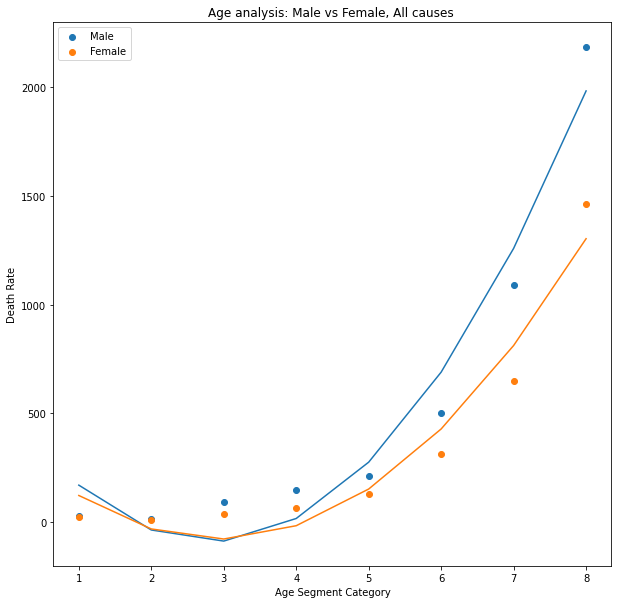

In [20]:
#Visualization
# Used matplotlib scatter function to recreate scatter plots in python.
# It was very easy to set up and I was able to copy-paste the code for the similar plots below, making the process much faster than doing it in excel.
plt.figure(figsize=(10,10))
plt.scatter(all_causes_gender_and_age_analysis.index, all_causes_gender_and_age_analysis["male"], label="Male")
plt.scatter(all_causes_gender_and_age_analysis.index, all_causes_gender_and_age_analysis["female"], label="Female")
plt.legend()
plt.xlabel("Age Segment Category")
plt.ylabel("Death Rate")

# Setting up values for the polynomial regression fitting.
X=all_causes_gender_and_age_analysis.index.values
y_male=all_causes_gender_and_age_analysis["male"].values
y_female=all_causes_gender_and_age_analysis["female"].values

y_pred_male = poly_reg_eval(X,y_male)
y_pred_female = poly_reg_eval(X,y_female)

# Used matplotlip plot function for plotting regression lines and scikitlearn r2_score function to find how closely the predicted line fits the raw data
# I got almost the same results, except the excel poly fit functionality predicted a closer fit. There's probably a slight difference between the excel poly fit method and 
# the scikitlearn poly fit calculation process, but the general trends are the same.
plt.plot(X, y_pred_male);
print("Male R^2 Score:")
print(r2_score(y_male, y_pred_male))

plt.plot(X, y_pred_female);
plt.title("Age analysis: Male vs Female, All causes ")
print("Female R^2 Score:")
print(r2_score(y_female, y_pred_female))
plt.show()

In [21]:
## ASSAULTS: male vs female
# I used the same analysis method as the above "All causes: male vs female" section to evaluate statistical significance and visualize results for assaults and accidents.
assaults_gender_and_age_analysis = pd.pivot_table(cleaned_raw_data[
    cleaned_raw_data["Cause of Death"] == ("Assault (homicide) (*U01-*U02,X85-Y09,Y87.1)")],
                                                    values='Rate Modified',
                                                    index="Age Segment Category",
                                                    columns=["Sex Segment"]).dropna().drop("both sexes",1)

assaults_gender_numbers = pd.pivot_table(cleaned_raw_data[
    cleaned_raw_data["Cause of Death"]=="Assault (homicide) (*U01-*U02,X85-Y09,Y87.1)"],
                                                    values='Number',
                                                    index="Age Segment Category",
                                                    columns=["Sex Segment"]).dropna()

assaults_gender_numbers['female']=assaults_gender_numbers["both sexes"]-assaults_gender_numbers["male"]
assaults_gender_and_age_analysis['female'] = round((assaults_gender_numbers['female']/total_population_gender['female'])*100000,2)
assaults_gender_and_age_analysis['Statistically Significant?']=assaults_gender_and_age_analysis.apply(
    lambda row: test_significance(row['male'],row['female'],100000), axis=1)

# One interesting thing to note here is that for Age Segment Category 5, excel calculations suggested that the difference was statistically significant while the
# python calculation suggested otherwise. There must be a difference between the excel NORMDIST function vs the scipy.stats.norm.sf function for calculating the p-value.
# The rest of the statistical significance assessments matched between the excel and python analyses.
assaults_gender_and_age_analysis

Sex Segment,male,female,Statistically Significant?
Age Segment Category,,,
1,2.3,1.95,NO
2,0.8,0.54,NO
3,16.7,2.63,YES
4,16.4,3.21,YES
5,10.1,2.74,NO
6,6.9,2.30,NO


Male R^2 Score:
0.6443103157704355
Female R^2 Score:
0.3437757633445788


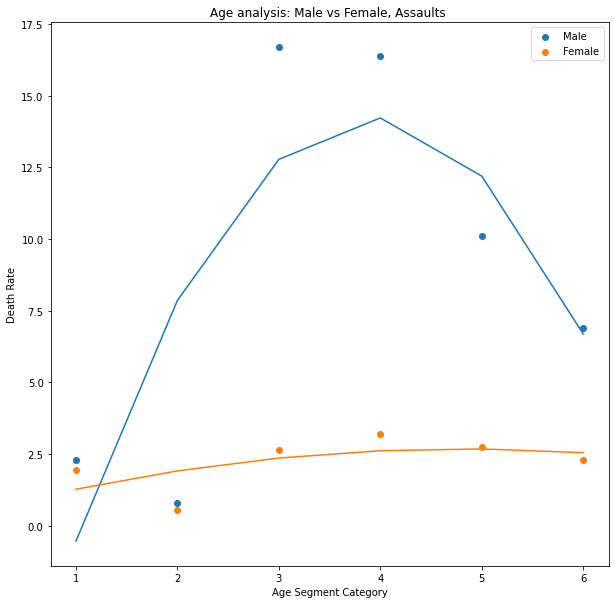

In [22]:
#Visualization
plt.figure(figsize=(10,10))
plt.scatter(assaults_gender_and_age_analysis.index, assaults_gender_and_age_analysis["male"], label="Male")
plt.scatter(assaults_gender_and_age_analysis.index, assaults_gender_and_age_analysis["female"], label="Female")
plt.legend()
plt.xlabel("Age Segment Category")
plt.ylabel("Death Rate")

X=assaults_gender_and_age_analysis.index.values
y_male=assaults_gender_and_age_analysis["male"].values
y_female=assaults_gender_and_age_analysis["female"].values

y_pred_male = poly_reg_eval(X,y_male)
y_pred_female = poly_reg_eval(X,y_female)

plt.plot(X, y_pred_male);
print("Male R^2 Score:")
print(r2_score(y_male, y_pred_male))

plt.plot(X, y_pred_female);
print("Female R^2 Score:")
print(r2_score(y_female, y_pred_female))

# The final R^2 score matched between the excel and python calculations here! 
plt.title("Age analysis: Male vs Female, Assaults ")
plt.show()

In [23]:
## ACCIDENTS: male vs female
accidents_gender_and_age_analysis = pd.pivot_table(cleaned_raw_data[
    cleaned_raw_data["Cause of Death"] == ("Accidents (unintentional injuries) (V01-X59,Y85-Y86)")],
                                                    values='Rate Modified',
                                                    index="Age Segment Category",
                                                    columns=["Sex Segment"]).dropna().drop(11).drop("both sexes",1)
# Female: Calculate number of deaths per age category by subtracting male number from both sexes number.
accidents_gender_numbers = pd.pivot_table(cleaned_raw_data[
    cleaned_raw_data["Cause of Death"]=="Accidents (unintentional injuries) (V01-X59,Y85-Y86)"],
                                                    values='Number',
                                                    index="Age Segment Category",
                                                    columns=["Sex Segment"]).dropna().drop(11)
accidents_gender_numbers['female']=accidents_gender_numbers["both sexes"]-accidents_gender_numbers["male"]
accidents_gender_and_age_analysis['female'] = round((accidents_gender_numbers['female']/total_population_gender['female'])*100000,2)
accidents_gender_and_age_analysis['Statistically Significant?']=accidents_gender_and_age_analysis.apply(
    lambda row: test_significance(row['male'],row['female'],100000), axis=1)
accidents_gender_and_age_analysis

Sex Segment,male,female,Statistically Significant?
Age Segment Category,,,
1,10.2,6.19,NO
2,4.5,2.85,NO
3,37.9,14.35,YES
4,55.6,19.73,YES
5,52.4,23.58,YES
6,63.0,30.49,YES
7,61.5,26.52,YES
8,59.5,29.46,YES


Male R^2 Score:
0.8922984292496796
Female R^2 Score:
0.90494541816998


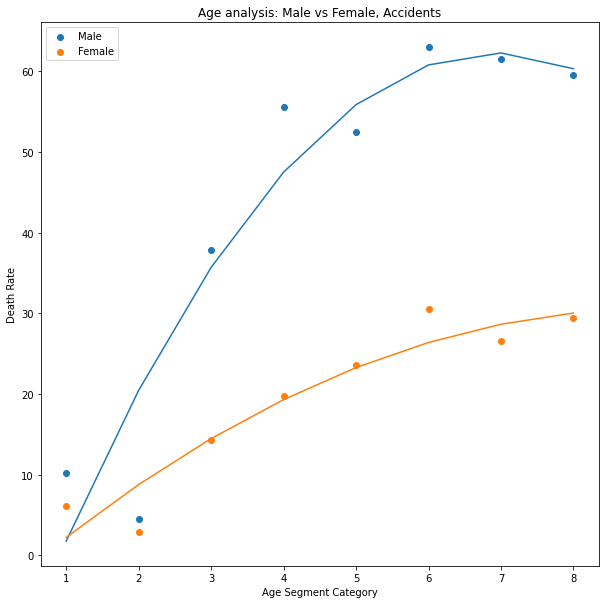

In [ ]:
#Visualization
plt.figure(figsize=(10,10))
plt.scatter(accidents_gender_and_age_analysis.index, accidents_gender_and_age_analysis["male"], label="Male")
plt.scatter(accidents_gender_and_age_analysis.index, accidents_gender_and_age_analysis["female"], label="Female")
plt.legend()
plt.xlabel("Age Segment Category")
plt.ylabel("Death Rate")

X=accidents_gender_and_age_analysis.index.values
y_male=accidents_gender_and_age_analysis["male"].values
y_female=accidents_gender_and_age_analysis["female"].values

y_pred_male = poly_reg_eval(X,y_male)
y_pred_female = poly_reg_eval(X,y_female)

plt.plot(X, y_pred_male);
print("Male R^2 Score:")
print(r2_score(y_male, y_pred_male))

plt.plot(X, y_pred_female);
print("Female R^2 Score:")
print(r2_score(y_female, y_pred_female))

#The female fit was far stronger here than in the excel polynomial fit. In excel, the R^2 score was 0.78 while the python calculation shows 0.90.
plt.title("Age analysis: Male vs Female, Accidents")
plt.show()

In [ ]:
# Male vs Female: Age 15-24, Top 5 Causes of Death
# Top 5 causes of death for both sexes age 15-24
# The calculations here are similar to the above male vs female analysis sections, with modified filters and settings matching the pivot table in the Analysis sheet in excel.
age_15_24_top_5_causes_of_death = cleaned_raw_data[(cleaned_raw_data["RANK"].isin(range(1,6)))
                                   & (cleaned_raw_data["Sex Segment"]=="both sexes") 
                                   & (cleaned_raw_data["Age Segment Category"]==3)]["Cause of Death"]
age_15_24_gender_analysis = pd.pivot_table(cleaned_raw_data[
    (cleaned_raw_data["Cause of Death"].isin(age_15_24_top_5_causes_of_death.values))
    & (cleaned_raw_data["Age Segment Category"]==3)],
                                                    values="Rate Modified",
                                                    index="Cause of Death",
                                                    columns=["Sex Segment"]).dropna().drop("both sexes",1)

age_15_24_gender_numbers = pd.pivot_table(cleaned_raw_data[
    (cleaned_raw_data["Cause of Death"].isin(age_15_24_top_5_causes_of_death.values))
    & (cleaned_raw_data["Age Segment Category"]==3)],
                                                    values='Number',
                                                    index="Cause of Death",
                                                    columns=["Sex Segment"]).dropna()

age_15_24_gender_numbers['female']=age_15_24_gender_numbers["both sexes"]-age_15_24_gender_numbers["male"]
age_15_24_gender_analysis['female'] = round((age_15_24_gender_numbers['female']/total_population_gender['female'][3])*100000,2)
age_15_24_gender_analysis['Statistically Significant?']=age_15_24_gender_analysis.apply(
    lambda row: test_significance(row['male'],row['female'],100000), axis=1)

#As shown below, the results of this analysis are the same as described in the excel deliverable and accompanying analysis report.
age_15_24_gender_analysis.sort_values("male")

Sex Segment,male,female,Statistically Significant?
Cause of Death,,,
"Diseases of heart (I00-I09,I11,I13,I20-I51)",2.8,1.46,NO
Malignant neoplasms (C00-C97),3.8,2.97,NO
"Assault (homicide) (*U01-*U02,X85-Y09,Y87.1)",16.7,2.63,YES
"Intentional self-harm (suicide) (*U03,X60-X84,Y87.0)",17.3,4.55,YES
"Accidents (unintentional injuries) (V01-X59,Y85-Y86)",37.9,14.35,YES


<Figure size 432x288 with 0 Axes>

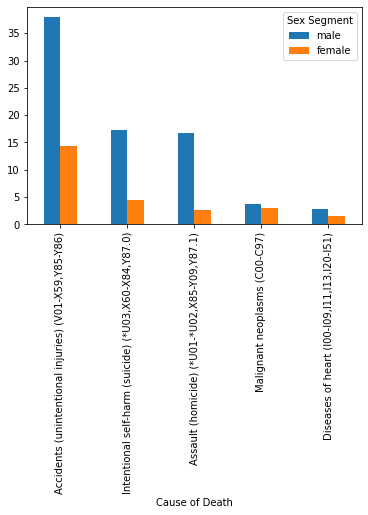

In [ ]:
# Visualization
# I used the dataframe "plot" library's "bar()" method to create the bar plot easily. It was much easier to do this in python than in excel. 
fig = plt.figure()
ax = age_15_24_gender_analysis.sort_values("male", ascending=False).plot.bar()

In [ ]:
### AGE ANALYSIS ###
# Created the same pivot table as in the "Analysis" sheet in my excel deliverable 
age_analysis_by_number = pd.pivot_table(cleaned_raw_data[
    (cleaned_raw_data["Sex Segment"]=="both sexes")&
    (~cleaned_raw_data["Cause of Death"].isin(["All causes", "All other causes (Residual)"]))],
                                        values='Number',
                                        index=['Cause of Death'],
                                        columns=['Age Segment Category'], aggfunc=np.sum) #used the "aggfunc" parameter to specify to use the numpy np.sum method to sum all values across sexes for each category

# Created new 'Sum' column and used pandas dataframe "sort_values" method to sort dataframe by the sum of values across age cateogries
age_analysis_by_number["Sum"]=age_analysis_by_number.sum(1) 
age_analysis_by_number.sort_values(by="Sum",ascending=False).drop("Sum",1)

Age Segment Category,1,2,3,4,5,6,7,8,9,10,11
Cause of Death,,,,,,,,,,,
"Diseases of heart (I00-I09,I11,I13,I20-I51)",169.0,173.0,941.0,3258.0,10341.0,35167.0,72568.0,98432.0,147255.0,242469.0,611105.0
Malignant neoplasms (C00-C97),328.0,895.0,1496.0,3673.0,11349.0,46185.0,113324.0,155552.0,153214.0,98792.0,584881.0
Chronic lower respiratory diseases (J40-J47),64.0,155.0,155.0,291.0,760.0,4619.0,15942.0,35603.0,49346.0,42245.0,149205.0
"Accidents (unintentional injuries) (V01-X59,Y85-Y86)",1316.0,1521.0,11619.0,16209.0,15354.0,20357.0,17057.0,10967.0,14438.0,20537.0,130557.0
Cerebrovascular diseases (I60-I69),38.0,89.0,153.0,508.0,1687.0,5425.0,11364.0,18722.0,36151.0,54729.0,128978.0
Alzheimer's disease (G30),NaN,NaN,NaN,NaN,NaN,NaN,NaN,4561.0,23073.0,56152.0,84767.0
Diabetes mellitus (E10-E14),NaN,24.0,193.0,684.0,1952.0,5899.0,13061.0,17279.0,19587.0,16885.0,75578.0
Influenza and pneumonia (J09-J18),102.0,128.0,197.0,449.0,881.0,2233.0,4779.0,7441.0,13949.0,26641.0,56979.0
"Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)",NaN,NaN,NaN,266.0,627.0,2025.0,4947.0,8524.0,13317.0,17239.0,47112.0


In [ ]:
#Same age analysis as above but using the "Rate Modified" values rather than raw death numbers since it's more accurate to compare with rates rather than numbers.
age_analysis_by_rate = pd.pivot_table(cleaned_raw_data[(~cleaned_raw_data["Cause of Death"].isin(["All causes", "All other causes (Residual)"]))&
                                                      (cleaned_raw_data["Sex Segment"]=="both sexes")],
                                      values='Rate Modified',
                                      index=['Cause of Death'],
                                      columns=['Age Segment Category'],
                                      aggfunc=np.sum)
age_analysis_by_rate["Sum"]=age_analysis_by_number.sum(1)
age_analysis_by_rate = age_analysis_by_rate.sort_values(by="Sum",ascending=False).drop("Sum",1)

In [ ]:
#Visualization
# Used pandas dataframe "rank" method to rank values in each row, the same way I ranked in the Dashboard tab in excel. (1 being highest death rate, 10 being lowest).
#I'll be basing my heatmap off of these rank numbers
# I did not drop NaN values to make final heatmap clearer, I didn't want any color assigned to those cells.
plot_age_analysis_by_rate = age_analysis_by_rate.drop([11],1)
plot_age_analysis_by_rate = plot_age_analysis_by_rate.rank(axis=1, ascending=False)
plot_age_analysis_by_rate


Age Segment Category,1,2,3,4,5,6,7,8,9,10
Cause of Death,,,,,,,,,,
"Diseases of heart (I00-I09,I11,I13,I20-I51)",9.0,10.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
Malignant neoplasms (C00-C97),10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
Chronic lower respiratory diseases (J40-J47),9.0,9.0,9.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
"Accidents (unintentional injuries) (V01-X59,Y85-Y86)",9.0,10.0,8.0,7.0,6.0,3.0,5.0,4.0,2.0,1.0
Cerebrovascular diseases (I60-I69),9.5,9.5,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
Alzheimer's disease (G30),NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,1.0
Diabetes mellitus (E10-E14),NaN,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
Influenza and pneumonia (J09-J18),8.0,10.0,9.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
"Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)",NaN,NaN,NaN,7.0,6.0,5.0,4.0,3.0,2.0,1.0


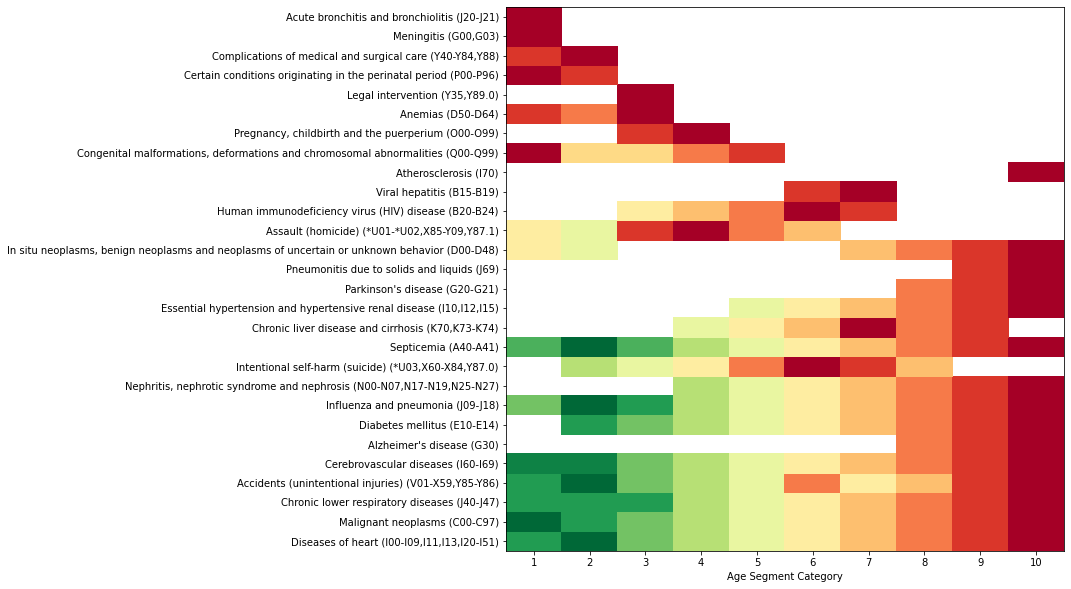

In [ ]:
plt.figure(figsize=(10,10))

# Used matplotlib's "pcolor" method to create the heatmap using the built-in color map "RdYlGn" to achieve the same Red-Green gradient I used in the excel Dashboard sheet
plt.pcolor(plot_age_analysis_by_rate,cmap = "RdYlGn")
plt.yticks(np.arange(0.5, len(plot_age_analysis_by_rate.index), 1),plot_age_analysis_by_rate.index)
plt.xlabel(plot_age_analysis_by_rate.columns.name)
plt.xticks(np.arange(0.5, len(plot_age_analysis_by_rate.columns), 1),plot_age_analysis_by_rate.columns)
plt.show()

In [ ]:
# The resulting heat map showed the same results as the one I made in excel.

## Excel vs python
# Overall, the results of the analysis are the same except for the couple discrepancies I called out in this notebook. The minor discrepancies were due to differences in 
# built in functions used.
# Refer to the analysis report PDF for detailed insights -- as the results are largely the same from this exercise, the insights/conclusions are as well.

## CONCLUSIONS
# Males had a generally statistically significant death rate than females for the causes of death in the "All causes" "both sexes" category
# starting from the 15-24 year age segment. This is an interesting and important finding since it reveals a need to close this gap and to find ways to bring the male
# death rate down.

# For assaults, males age 15-24 and 25-34 years were at statistically significantly higher risk of death than females. Further studies can be done to understand why -- there
# may be psychological, socio-political, physical, or financial reasons for this.

# For accidents, males above 15 years of age are at a higher risk of death than females. Further studies can be done here as well to understand why and to develop
# preventative measures to help close the gap and reduce the male death rate. 

# Males in the 15-24 years age segment have a statistically significantly higher death rate than females for suicide. This is important for agencies such as Suicide Prevention
# to know and dive deeper into the underlying reason. Perhaps mental health organizations can provide resources aimed at males in that age group to improve their mental health
# and prevent suicides. 

#The age analysis heat map showed red sections for a collection of diseases in the older age segment categories (7-10) and a different collection of diseases that only significantly
#affect the younger demographics (age segment categories 1-5). Some diseases only showed up in the top 15 for specific age categories. This shows that age certainly correlates
# with death rates for different causes of death. 